In [1]:

import os,sys
import numpy as np
import scipy as sp
import pandas as pd
#from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta, time
import glob
from generate_atmosphere import LidarProfile,RadiosondeProfile
import miscLidar as mscLid
from molecular import rayleigh_scattering
import global_settings as gs
import pandas as pd
#import ARLreader as Ar
import preprocessing as prep
import matplotlib.dates as mdates

C:\Users\addalin\Dropbox\Lidar\code\miscLidar.py:40: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]


In [2]:
def gdas2radiosonde(src_file,dst_file,
        col_names = ['PRES','HGHT','TEMP','UWND',
                     'VWND','WWND','RELH','TPOT','WDIR','WSPD']):
	'''
	Helper function that converts a gdas file from TROPOS server, to a simple txt.
	The resulting file is without any prior info, and resembles the table format
	of a radiosonde file (see class: RadiosondeProfile)
	:param src_file: source file name
	:param dst_file: destination file name
	:param col_names: column names of the final table
	'''
	import pandas as pd
	from pandas.api.types import is_numeric_dtype

	data_src = pd.read_fwf(src_file,skiprows=[0,1,2,3,4,5,6,8],
	                       delimiter="\s+",skipinitialspace=True).dropna()
	# converting any kind of blanc spaces to zeros
	for col in data_src.columns:
		if not is_numeric_dtype(data_src[col]):
			data_src[col]= pd.core.strings.str_strip(data_src[col])
			data_src[col]= data_src[col].replace('','0').astype('float64')
	data_src.columns = col_names
	data_src.to_csv(dst_file,index=False,sep='\t',na_rep='\t')
	# TODO: add warning if failed
def extract_date_time(path,format_filename,format_times):
	# Extracting datetime from file name using a formatter string.
	#
	# Usage:
	# create a formatter string: format_filename=  r'-(.*)_(.*)-(.*)-.*.txt'
	# Call the function:        f time_stamp = extract_date_time(soundePath,r'40179_(.*).txt',['%Y%m%d_%H'])
	# Output:
	#       time_stamps - A list of datetime objects
	import re
	filename = os.path.basename(path)
	#print(filename)
	matchObj = re.match(format_filename, filename, re.M|re.I)
	# print(matchObj)
	time_stamps=[]
	for fmt_time,grp in zip(format_times,matchObj.groups()):
		time_stamps.append(datetime.strptime(grp,fmt_time))
	return time_stamps
def calc_sigma_profile_df(row,lambda_um = 532.0,indx_n= 'sigma'):
	'''
	Returns pd series of extinction profile [1/m] from a radiosonde dataframe containing the
	columns:['PRES','TEMPS',RELHS]. The function applies on rows of the radiosonde df.
	:param row: row of radiosonde df
	:param lambda_um: wavelength in [um], e.g, for green lambda_um = 532.0 [um]
	:param indx_n: index name, the column name of the result. The default is 'sigma'
	but could be useful to get profiles for several hours each have a different index name
	(e.g., datetime object of measuring time of the radiosonde as datetime.datetime(2017, 9, 2, 0, 0))
	:return: pd series of extinction profile [1/m]
	'''
	return pd.Series([rayleigh_scattering.alpha_rayleigh(wavelength= lambda_um,
	                                       pressure=row['PRES'],
	                                       temperature=row['TEMPS'],
	                                       C=385.0, rh=row['RELHS'])],index=[indx_n])
def calc_beta_profile_df(row,lambda_um = 532.0,ind_n= 'beta'):
	"""
	Returns pd series of backscatter profile from a radiosonde dataframe containing the
	columns:['PRES','TEMPS',RELHS]. The function applies on rows of the radiosonde df.
	:param row: row of radiosonde df
	:param lambda_um: wavelength in [um], e.g, for green lambda_um = 532.0 [um]
	:param indx_n: index name, the column name of the result. The default is 'beta'
	but could be useful to get profiles for several hours each have a different index name
	(e.g., datetime object of measuring time of the radiosonde as datetime.datetime(2017, 9, 2, 0, 0))
	:return: pd series of backscatter profile [1/sr*m]
	"""
	return pd.Series([rayleigh_scattering.beta_pi_rayleigh(wavelength= lambda_um,
	                                       pressure=row['PRES'],
	                                       temperature=row['TEMPS'],
	                                       C=385.0, rh=row['RELHS'])],index=[ind_n])

In [3]:
'''set day'''

day_date = datetime(2017,9,1)

'''Set paths to parents folder '''
lidar_parent_folder = 'H:\data_haifa\DATA FROM TROPOS\data\level1a\PollyXT_TROPOS'
gdas_parent_folder = 'H:\data_haifa\DATA FROM TROPOS\GDAS\haifa'


In [4]:
lidar_day_folder = os.path.join(lidar_parent_folder,day_date.strftime("%Y\%m\%d"))
os.listdir(lidar_day_folder)
bsc_pattern = os.path.join(lidar_day_folder,"*_att_bsc.nc")
bsc_paths = sorted(glob.glob(bsc_pattern))
#bsc_paths
profile_pattern = os.path.join(lidar_day_folder,"*[0-9]_profiles.nc")
profile_paths = sorted(glob.glob(profile_pattern))
#profile_paths


In [ ]:
haifa_station = gs.station()
#print(haifa_station.__dict__)
src_folder =os.path.join(os.getcwd(),'data examples\gdas')
dst_folder = os.path.join(os.getcwd(),'data examples\gdas_txt')
gdas_dst_paths= prep.gdas_tropos2txt(day_date, haifa_station.location,
                                   haifa_station.lat, haifa_station.lon,
                                   src_folder, dst_folder)

In [ ]:
'''set parameters'''
lambda_um = gs.LAMBDA_um().G
location = haifa_station.location
min_height_km = (1E-3)*(haifa_station.altitude + haifa_station.start_bin_height)
top_height_km = (1E-3)*(haifa_station.altitude + haifa_station.end_bin_height)

df_sigma, df_beta = prep.generate_daily_molecular_profile(
	gdas_dst_paths,lambda_um,haifa_station.location, haifa_station.lat,
	haifa_station.lon,min_height_km , top_height_km,haifa_station.n_bins)

df_sigma

<Figure size 432x288 with 0 Axes>

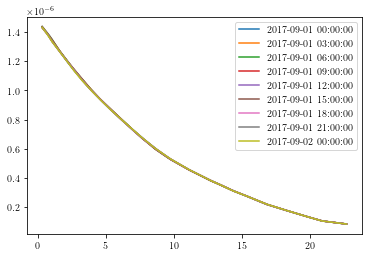

In [8]:
plt.figure()
df_beta.plot()
plt.show()

In [16]:
def cal_e_tau_df(col,altitude):
	"""
	Calculate the the attenuated optical depth (tau is the optical depth).
	Calculation is per column of the backscatter (sigma) dataframe
	:param col: column of sigma_df
	:param altitude: the altitude of the the lidar station above sea level
	:return: Series of exp(-2*tau)  , tau = integral( sigma(r) * dr)
	"""
	# TODO: validate height scale (m or km)
	heights = col.index.to_numpy() - altitude
	tau = mscLid.calc_tau(col, heights)
	return pd.Series(np.exp(-2 * tau))

def generate_att_bsc_mol(lambda_um, station, time_res='30S'):
	"""	 """

	'''Load daily gdas profiles and convert to backscatter (beta) and extinction (sigma) profiles'''
	min_height_km = (station.altitude + station.start_bin_height) * 1E-3
	top_height_km = (station.altitude + station.end_bin_height) * 1E-3

	df_sigma, df_beta = prep.generate_daily_molecular_profile(
		gdas_dst_paths,lambda_um,station.location, station.lat,
		station.lon,min_height_km , top_height_km,station.n_bins)

	''' Interpolate profiles through 24 hrs'''
	interp_sigma_df=(df_sigma.T.resample(time_res).interpolate(method='linear')[:-1]).T
	interp_beta_df=(df_beta.T.resample(time_res).interpolate(method='linear')[:-1]).T
	heights = np.linspace(station.altitude + station.start_bin_height,
                      station.altitude + station.end_bin_height,
                      station.n_bins)
	interp_sigma_df.index = heights
	interp_sigma_df.columns.freq = None
	interp_beta_df.index = heights
	interp_beta_df.columns.freq = None

	'''Calculate the molecular attenuated backscatter as :  beta_mol * exp(-2*tau_mol)'''
	e_tau_df = interp_sigma_df.apply(cal_e_tau_df,0,args=(haifa_station.altitude,),result_type='expand')
	att_bsc_mol_df = interp_beta_df.multiply(e_tau_df)


	import xarray as xr
	mol_xr= xr.DataArray(data=[interp_beta_df,interp_sigma_df,att_bsc_mol_df],
                     coords=[['beta','sigma','att_bsc_mol'],interp_beta_df.index,interp_beta_df.columns],
                     dims = ['profiles','height','time'],
                     name='molecular')#,interp_beta_df.index,interp_beta_df.columns )



	return att_bsc_mol_df,mol_xr

In [11]:
print('df_mol')
lambda_um = gs.LAMBDA_um().G
location = haifa_station.location
mol_df,mol_xr = generate_att_bsc_mol(lambda_um, haifa_station, time_res='30S')
mol_xr

# TODO: make sure mol_df units has consistant units 1/m vs 1/km
# TODO: define attributes of mol_xr
# TODO: create xarray to a daily molecular profile for three channels
# TODO: convert from xarray to pytorch

df_mol


<xarray.DataArray 'molecular' (profiles: 3, height: 3000, time: 2880)>
array([[[1.43876581e-06, 1.43876355e-06, 1.43876129e-06, ...,
         1.43152413e-06, 1.43152573e-06, 1.43152734e-06],
        [1.43790604e-06, 1.43790375e-06, 1.43790147e-06, ...,
         1.43063545e-06, 1.43063697e-06, 1.43063848e-06],
        [1.43704599e-06, 1.43704369e-06, 1.43704139e-06, ...,
         1.42974639e-06, 1.42974782e-06, 1.42974924e-06],
        ...,
        [8.38648559e-08, 8.38651337e-08, 8.38654115e-08, ...,
         8.36953909e-08, 8.36948784e-08, 8.36943660e-08],
        [8.37789800e-08, 8.37792581e-08, 8.37795362e-08, ...,
         8.36089534e-08, 8.36084399e-08, 8.36079264e-08],
        [8.36931164e-08, 8.36933948e-08, 8.36936732e-08, ...,
         8.35225293e-08, 8.35220147e-08, 8.35215002e-08]],

       [[1.22213220e-05, 1.22213023e-05, 1.22212825e-05, ...,
         1.21590354e-05, 1.21590491e-05, 1.21590627e-05],
        [1.22140184e-05, 1.22139984e-05, 1.22139784e-05, ...,
         1.21514925e-05, 1.21515054e-05, 1.21515183e-05],
        [1.22067123e-05, 1.22066922e-05, 1.22066721e-05, ...,
         1.21439463e-05, 1.21439585e-05, 1.21439706e-05],
...
        [7.12568384e-07, 7.12570744e-07, 7.12573104e-07, ...,
         7.11128503e-07, 7.11124149e-07, 7.11119794e-07],
        [7.11838728e-07, 7.11841091e-07, 7.11843454e-07, ...,
         7.10394076e-07, 7.10389713e-07, 7.10385350e-07],
        [7.11109177e-07, 7.11111543e-07, 7.11113908e-07, ...,
         7.09659762e-07, 7.09655390e-07, 7.09651018e-07]],

       [[1.43599905e-06, 1.43599680e-06, 1.43599455e-06, ...,
         1.42878531e-06, 1.42878691e-06, 1.42878851e-06],
        [1.43487903e-06, 1.43487675e-06, 1.43487447e-06, ...,
         1.42763908e-06, 1.42764059e-06, 1.42764210e-06],
        [1.43375924e-06, 1.43375695e-06, 1.43375466e-06, ...,
         1.42649301e-06, 1.42649442e-06, 1.42649584e-06],
        ...,
        [6.81102815e-08, 6.81105007e-08, 6.81107199e-08, ...,
         6.79896568e-08, 6.79892503e-08, 6.79888438e-08],
        [6.80398142e-08, 6.80400337e-08, 6.80402531e-08, ...,
         6.79187186e-08, 6.79183113e-08, 6.79179039e-08],
        [6.79693591e-08, 6.79695789e-08, 6.79697986e-08, ...,
         6.78477935e-08, 6.78473853e-08, 6.78469771e-08]]])
Coordinates:
  * profiles  (profiles) <U11 'beta' 'sigma' 'att_bsc_mol'
  * height    (height) float64 307.8 315.2 322.7 ... 2.271e+04 2.271e+04
  * time      (time) datetime64[ns] 2017-09-01 ... 2017-09-01T23:59:30

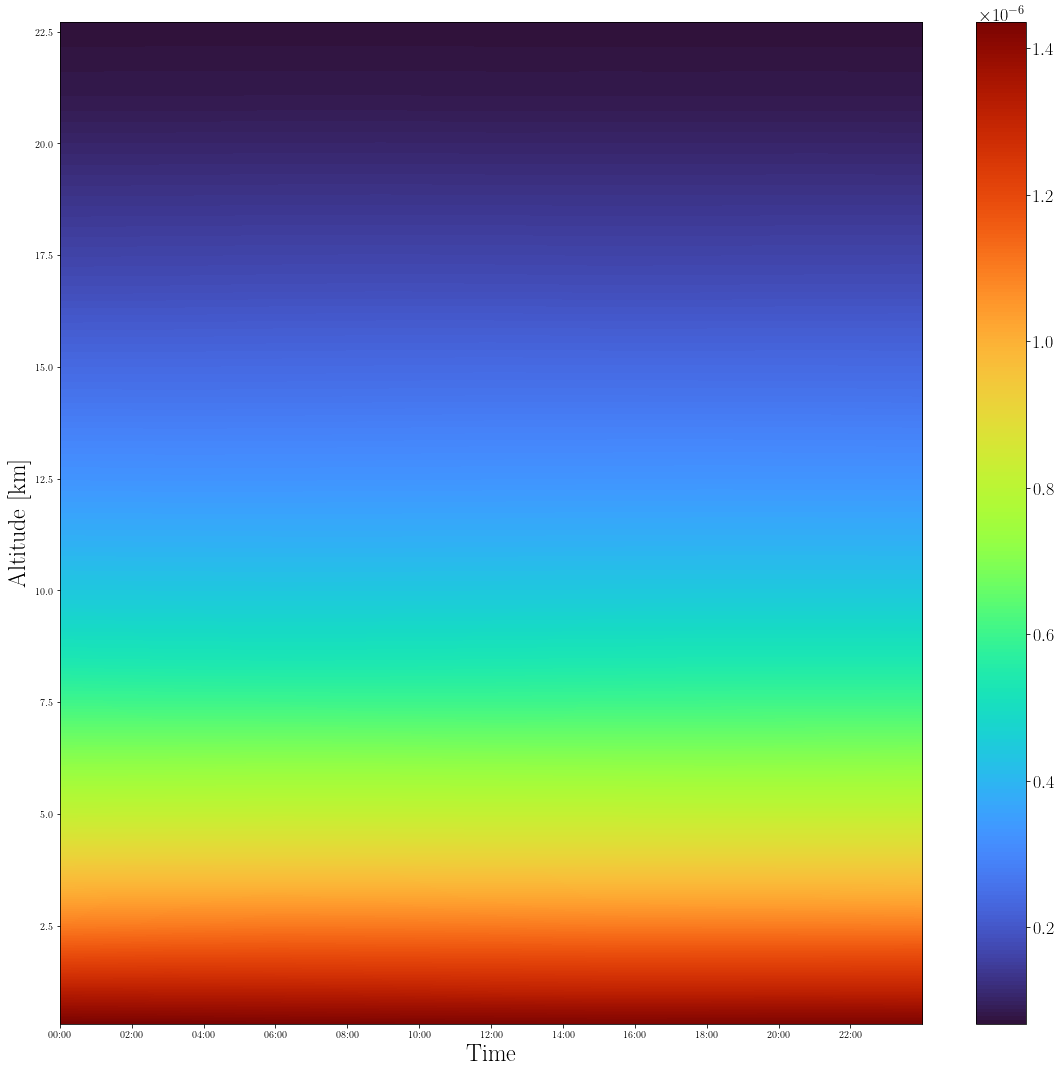

In [12]:
cur_df= mol_df
x_lims = mdates.date2num([cur_df.columns[0],cur_df.columns[-1]])
y_lims = [cur_df.index[0]*1E-3, cur_df.index[-1]*1E-3]
extent = [x_lims[0],x_lims[1],y_lims[0],y_lims[1] ]
fig, ax = plt.subplots(figsize=(16,15))
im = ax.imshow(cur_df, origin='lower',aspect='auto',cmap = 'turbo',
               extent=extent)#[0,2779,interp_sigma_df.index[0], interp_sigma_df.index[-1]])

ax.set_ylabel('Altitude [km]',fontsize =24)
ax.set_xlabel('Time',fontsize =24)
plt.rc('xtick',labelsize =18)
plt.rc('ytick',labelsize=18)
fig.colorbar(im,ax= ax)
ax.xaxis_date()
ax.get_xaxis().set_major_locator(mdates.MinuteLocator(interval=120))
xfmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
fig.tight_layout()
plt.show()

In [13]:
''' read radiosonde at 00:00 and 12:00 and 00:00 (of the day after)'''
## radiosonde download and analysis from cameranetwork

''' read gdas data for 00:00, 03:00, 06:00, 09:00 ,12:00, 15:00 , 18:00 ,21:00, 24:00'''
## use: https://github.com/martin-rdz/ARLreader


## AERONET : https://aeronet.gsfc.nasa.gov/cgi-bin/data_display_aod_v3?site=Technion_Haifa_IL&nachal=0&year=2017&month=5&day=19&aero_water=0&level=3&if_day=0&if_err=0&place_code=10&DATA_TYPE=-999&year_or_month=3
## it is possible to merge with Terra MODIS or Aqua MODIS -
# / TODO: locate the function that does donwload of sunphotometer data to cameranetwork (maybe Shubi knows this)
# / TODO: ask about the relevant product from MODIS to our porpose.
''' Interpolate on molecular profiles on a 2D grid 00:00-23:59 '''

' Interpolate on molecular profiles on a 2D grid 00:00-23:59 '

In [14]:
# for the followings :
# X = {lidar measurement (range corrected) molecular (range corrected)}
# Y = {lidar const, reference height [min,max]}